In [2]:
# %%
import pandas as pd
import pymysql
from pymysql.cursors import DictCursor
from sqlalchemy import create_engine, text
from sqlalchemy_utils import database_exists, create_database
import os
import numpy as np
# %%
# MySQL 연결 정보
db_config = {
    'host': 'changsoft1.iptime.org',
    'port': 18800,
    'user': 'changsoft',
    'password': 'chang2008!',
    'database': 'structure'
}

db_url = f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

engine = create_engine(db_url)

db_name = db_config['database']

try:
    connection = engine.connect()
    if connection:
        print(f"Successfully connected to database {db_name}")
    else:
        print("Failed to create connection")
        exit()
except Exception as e:
    print(f"An error occurred when trying to connect to database {db_name}: {str(e)}")
    exit()


Successfully connected to database structure


In [3]:
building_id = 1  # 적절한 빌딩 ID로 변경

#특정 빌딩의 총 체적을 얻으려면 다음과 같이 쿼리를 작성할 수 있습니다.
query = f"""
SELECT SUM(concrete.volume) as total_volume
FROM concrete
JOIN floor ON concrete.floor_id = floor.id
WHERE floor.building_id = {building_id};
"""

result = pd.read_sql(query, engine)
print(result)


   total_volume
0  26187.317819


In [4]:
query = f"""
SELECT 
    building.building_name, 
    SUM(concrete.volume) as total_volume,
    AVG(concrete.volume) as average_volume,
    STD(concrete.volume) as stddev_volume,
    MAX(concrete.volume) as max_volume,
    MIN(concrete.volume) as min_volume
FROM concrete
JOIN floor ON concrete.floor_id = floor.id
JOIN building ON floor.building_id = building.id
GROUP BY building.building_name;
"""

result = pd.read_sql(query, engine)


In [5]:
result

,building_name,total_volume,average_volume,stddev_volume,max_volume,min_volume
0,1BL_고층부,26187.317819,2.053746,4.322175,31.110,0.006
1,1BL_저층부,27475.103872,6.083947,50.137235,1537.280,0.001
2,2BL_저층부,27566.252859,5.733414,46.583138,1492.290,0.000
3,2BL_고층부,26030.605857,2.094176,4.349501,31.110,0.006
4,[현대엔지니어링]가산DK현장 모델파일_22.08.01,55081.295942,4.807654,24.372040,1105.050,0.002
5,PIT~PHRF,10075.685972,0.911250,2.416393,67.816,0.001
6,B5F~2F,19710.728002,6.940397,63.266033,1662.230,0.000
7,계룡_덕산병원_3F~RF_220728,12575.041001,2.559023,2.176489,59.746,0.006
8,계룡_덕산병원_B1F~2F_220728,17493.955126,3.719744,10.053847,115.931,-289.573
9,계룡_덕산병원_FT~B2F_220728,36409.302724,7.968768,46.998164,1462.080,-344.546


In [6]:
from sqlalchemy.orm import Session
def get_building_info(building_name):
    # SQLAlchemy session 생성
    with Session(engine) as session:
        # 건물에 해당하는 층 가져오기
        floors = session.execute(text("""
        SELECT floor.id, floor.floor_number, floor.floor_name, floor.floor_area
        FROM floor
        JOIN building ON floor.building_id = building.id
        WHERE building.building_name = :building_name
        """), {'building_name': building_name}).fetchall()

        # 각 층에 대한 정보를 저장할 빈 리스트 생성
        floor_info = []

        for floor in floors:
            floor_id, floor_number, floor_name, floor_area = floor

            # 각 층별 concrete, rebar, formwork의 총량 계산
            result = session.execute(text("""
            SELECT 
                :floor_id as floor_id,
                (SELECT SUM(volume) FROM concrete WHERE floor_id = :floor_id) as total_concrete,
                (SELECT SUM(area) FROM formwork WHERE floor_id = :floor_id) as total_formwork,
                (SELECT SUM(rebar_weight) FROM rebar WHERE floor_id = :floor_id) as total_rebar
            """), {'floor_id': floor_id}).fetchone()

            # 층 면적당 concrete, formwork, rebar 계산
            area_concrete = result[1] / floor_area if floor_area else None
            area_formwork = result[2] / floor_area if floor_area else None
            area_rebar = result[3] / floor_area if floor_area else None

            floor_info.append((floor_number, floor_name, floor_area, result[1], result[2], result[3], area_concrete, area_formwork, area_rebar))

        # 결과를 데이터프레임으로 변환
        floor_info_df = pd.DataFrame(floor_info, columns=['floor_number', 'floor_name', 'floor_area', 'total_concrete', 'total_formwork', 'total_rebar', 'area_concrete', 'area_formwork', 'area_rebar'])

    return floor_info_df



In [7]:
# 건물명 입력
building_name = "[현대엔지니어링]가산DK현장 모델파일_22.08.01"

# 건물 정보 데이터프레임 얻기
df = get_building_info(building_name)


In [8]:
df

,floor_number,floor_name,floor_area,total_concrete,total_formwork,total_rebar,area_concrete,area_formwork,area_rebar
0,-5,BOTTOM,0.000000e+00,13235.496971,1922.914329,652.769341,NaN,NaN,NaN
1,-4,B4F,9.099680e+09,4686.913985,18019.870217,505.431746,5.150636e-07,0.000002,5.554390e-08
2,-3,B3F,9.110790e+09,4038.486997,15213.252307,395.234958,4.432642e-07,0.000002,4.338098e-08
3,-2,B2F,9.117560e+09,4028.409011,15861.507654,400.452660,4.418297e-07,0.000002,4.392103e-08
4,-1,B1F,8.864610e+09,5074.166003,21910.046721,586.522935,5.724071e-07,0.000002,6.616455e-08
5,1,1F,8.894260e+09,1718.663003,10352.250364,202.646393,1.932328e-07,0.000001,2.278395e-08
6,2,2F,2.891290e+09,1270.158995,6223.686253,151.743295,4.393053e-07,0.000002,5.248290e-08
7,3,3F,2.934450e+09,1306.418000,6631.632155,150.734984,4.452003e-07,0.000002,5.136737e-08
8,4,4F,3.067890e+09,1203.740000,5883.643048,140.959811,3.923674e-07,0.000002,4.594683e-08
9,5,5F,3.067680e+09,1200.441000,5896.654292,134.768919,3.913188e-07,0.000002,4.393187e-08


In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = "c:/Windows/Fonts/malgun.ttf" # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

C:\Users\indig\AppData\Local\Temp\ipykernel_25712\2303449192.py:14: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\indig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


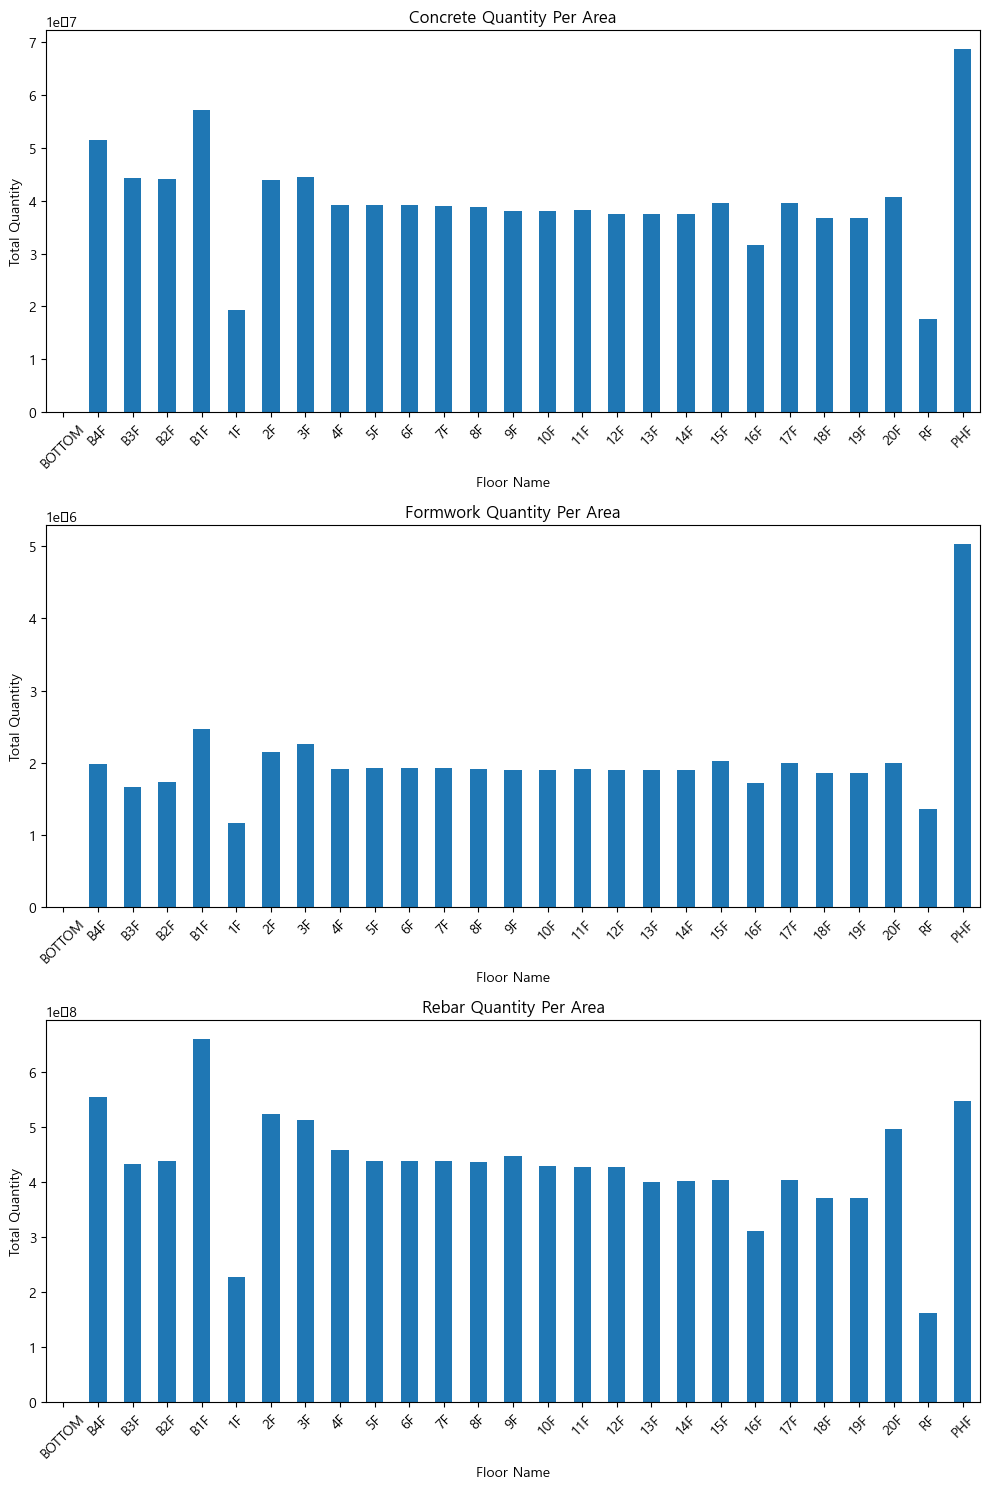

In [10]:


# 데이터 시각화
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

materials = ['area_concrete', 'area_formwork', 'area_rebar']
titles = ['Concrete Quantity Per Area', 'Formwork Quantity Per Area', 'Rebar Quantity Per Area']

for i, ax in enumerate(axs):
    df[materials[i]].plot(kind='bar', ax=ax)
    ax.set_xticklabels(df['floor_name'], rotation=45)
    ax.set_xlabel("Floor Name")
    ax.set_ylabel("Total Quantity")
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()


In [11]:
def calculate_metrics_per_project(engine):
    
    # 각 프로젝트의 총 면적을 계산
    area_df = pd.read_sql_query(text("""
        SELECT p.id AS project_id, p.project_name, SUM(f.floor_area) AS total_area
        FROM project AS p
        JOIN building AS b ON p.id = b.project_id
        JOIN floor AS f ON b.id = f.building_id
        GROUP BY p.id
    """), engine)

    # 각 프로젝트의 총 콘크리트 양을 계산
    concrete_df = pd.read_sql_query(text("""
        SELECT p.id AS project_id, SUM(c.volume) AS total_concrete
        FROM project AS p
        JOIN building AS b ON p.id = b.project_id
        JOIN floor AS f ON b.id = f.building_id
        JOIN concrete AS c ON f.id = c.floor_id
        GROUP BY p.id
    """), engine)

    # 각 프로젝트의 총 rebar 양을 계산
    rebar_df = pd.read_sql_query(text("""
        SELECT p.id AS project_id, SUM(r.rebar_weight) AS total_rebar
        FROM project AS p
        JOIN building AS b ON p.id = b.project_id
        JOIN floor AS f ON b.id = f.building_id
        JOIN rebar AS r ON f.id = r.floor_id
        GROUP BY p.id
    """), engine)

    # 각 프로젝트에 대한 총 면적, 총 콘크리트 양, 총 rebar 양을 결합
    result_df = pd.merge(area_df, concrete_df, on='project_id')
    result_df = pd.merge(result_df, rebar_df, on='project_id')

    # 각 프로젝트에 대한 면적당 콘크리트 양과 rebar 양을 계산
    result_df['concrete_per_area'] = result_df['total_concrete'] / result_df['total_area']
    result_df['rebar_per_area'] = result_df['total_rebar'] / result_df['total_area']

    # 결과를 반환
    return result_df

# 연결 문자열은 MySQL 서버의 세부 정보에 따라 변경되어야 합니다.

result_df = calculate_metrics_per_project(engine)


In [12]:
result_df

,project_id,project_name,total_area,total_concrete,total_rebar,concrete_per_area,rebar_per_area
0,1,신세계_어바인시티,1.645891e+11,107259.280406,7593.224818,6.516790e-07,4.613443e-08
1,2,DK TOWER 지식산업센터 신축공사,1.038666e+11,55081.295942,5198.751459,5.303081e-07,5.005220e-08
2,3,광명동 344번지 복합개발사업,4.471347e+10,29786.413974,2642.471316,6.661621e-07,5.909789e-08
3,4,덕산의료재단 수원덕산병원 신축공사,1.180691e+11,66478.298852,5696.066751,5.630455e-07,4.824348e-08
4,5,화성 송산그린시티 EB2 도시형생활주택 신축공사,2.101297e+10,13949.237991,1813.872694,6.638394e-07,8.632158e-08
5,6,화성 송산그린시티 EB3 도시형생활주택 신축공사,1.597163e+10,11071.866007,1517.769950,6.932207e-07,9.502911e-08


C:\Users\indig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


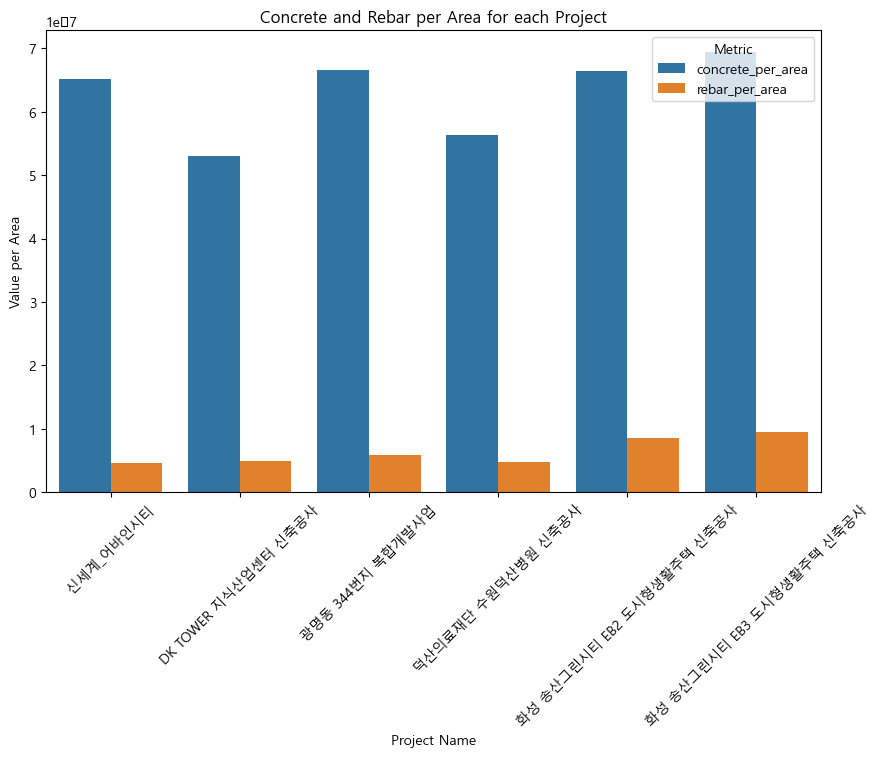

In [13]:

import seaborn as sns

def plot_separate_bar_chart(df):
    # 데이터프레임을 재구조화하여 면적당 콘크리트와 rebar의 양을 각각의 열로 만듭니다.
    df_melt = df.melt(id_vars='project_name', value_vars=['concrete_per_area', 'rebar_per_area'], var_name='Metric', value_name='Value')

    # 바 차트를 그립니다.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='project_name', y='Value', hue='Metric', data=df_melt)
    plt.xlabel('Project Name')
    plt.ylabel('Value per Area')
    plt.title('Concrete and Rebar per Area for each Project')
    plt.xticks(rotation=45)
    plt.show()


plot_separate_bar_chart(result_df)


In [14]:
def calculate_rebar_per_concrete_volume(engine, project_name):
    # 각 component type의 콘크리트 볼륨을 계산합니다.
    query_concrete = f"""
    SELECT 
        concrete.component_type as component_type,
        SUM(concrete.volume) as total_concrete_volume
    FROM 
        concrete 
        INNER JOIN floor ON concrete.floor_id = floor.id
        INNER JOIN building ON floor.building_id = building.id
        INNER JOIN project ON building.project_id = project.id
    WHERE
        project.project_name = '{project_name}'
    GROUP BY 
        component_type
    ORDER BY 
        component_type ASC
    """
    
    df_concrete = pd.read_sql_query(query_concrete, engine)
    
    # 각 component type의 rebar 무게를 계산합니다.
    query_rebar = f"""
    SELECT 
        rebar.component_type as component_type,
        SUM(rebar.rebar_weight) as total_rebar_weight
    FROM 
        rebar 
        INNER JOIN floor ON rebar.floor_id = floor.id
        INNER JOIN building ON floor.building_id = building.id
        INNER JOIN project ON building.project_id = project.id
    WHERE
        project.project_name = '{project_name}'
    GROUP BY 
        component_type
    ORDER BY 
        component_type ASC
    """

    df_rebar = pd.read_sql_query(query_rebar, engine)
    
    # 두 데이터프레임을 component_type 기준으로 병합합니다.
    df = pd.merge(df_concrete, df_rebar, on='component_type', how='inner')

    # 콘크리트 볼륨 당 rebar 무게를 계산합니다.
    df['rebar_weight_per_concrete_volume'] = df['total_rebar_weight'] / df['total_concrete_volume']

    # 프로젝트 이름을 추가합니다. 이렇게 하면 나중에 모든 프로젝트의 결과를 하나의 데이터프레임으로 합칠 때 각 결과가 어떤 프로젝트에 대한 것인지 알 수 있습니다.
    df['project_name'] = project_name
    
    return df[['project_name', 'component_type', 'rebar_weight_per_concrete_volume']]





In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_rebar_per_concrete_volume(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='component_type', y='rebar_weight_per_concrete_volume', hue='project_name', data=df)
    plt.xlabel('Component Type')
    plt.ylabel('Rebar Weight per Concrete Volume')
    plt.title('Rebar Weight per Concrete Volume for each Component Type')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()





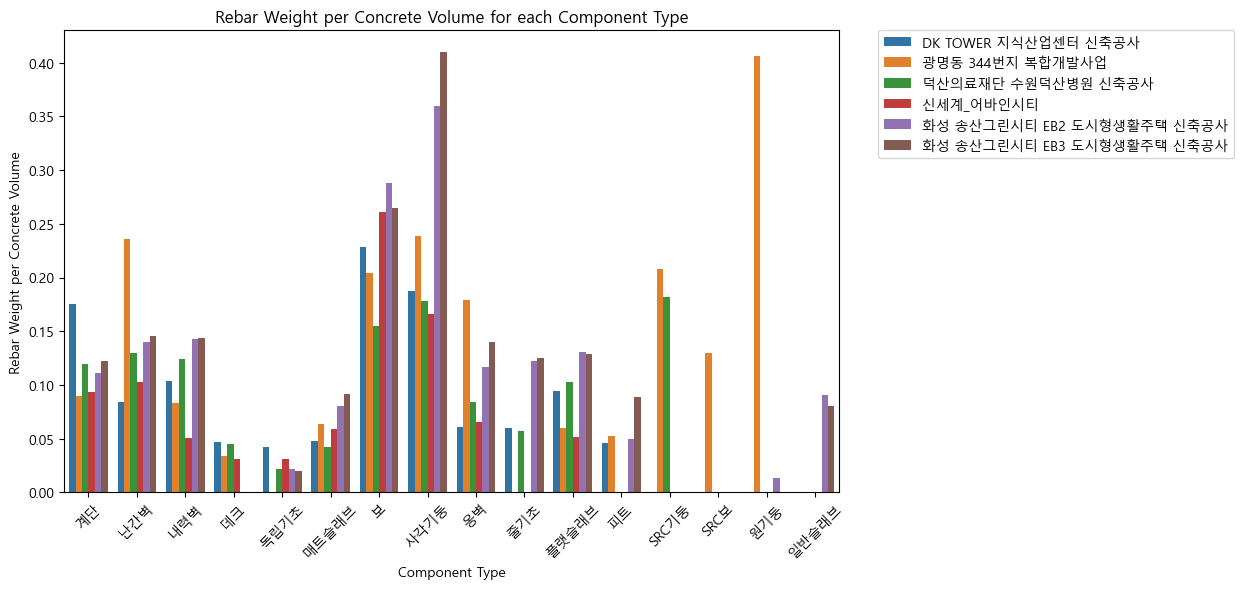

In [16]:

def calculate_for_all_projects(engine):
    # 'project' 테이블에서 모든 프로젝트 이름을 가져옵니다.
    query_project = "SELECT project_name FROM project"
    df_project = pd.read_sql_query(query_project, engine)

    # 결과를 저장할 빈 데이터프레임을 만듭니다.
    df_all = pd.DataFrame()

    # 각 프로젝트에 대해 calculate_rebar_per_concrete_volume() 함수를 실행하고 결과를 df_all에 추가합니다.
    for project_name in df_project['project_name']:
        df = calculate_rebar_per_concrete_volume(engine, project_name)
        df_all = pd.concat([df_all, df])
    
    return df_all


# 모든 프로젝트의 데이터를 가져옵니다.
df_all = calculate_for_all_projects(engine)

# 가져온 데이터로 바 차트를 그립니다.
plot_rebar_per_concrete_volume(df_all)




In [17]:
def get_unique_section_names(engine, table_name, component_type):
    query = f"SELECT DISTINCT section_name FROM {table_name} WHERE component_type = '{component_type}'"
    df = pd.read_sql(query, engine)
    return df['section_name'].tolist()


component_types = ['내력벽', '보', '옹벽']
for component_type in component_types:
    section_names = get_unique_section_names(engine, 'concrete', component_type)
    print(f"Unique section names in table concrete for component type '{component_type}': {section_names}")

Unique section names in table concrete for component type '내력벽': ['CW05', 'EW03', '84AW14', 'CW04', 'PW1(600이상)', '84AW22', '84BW13', 'EW18', '84CW01', '84BW11', '84BW17', 'EW15', 'CW14', '84AW17', 'CW01', 'EW05', 'PW2(600이상)', '84BW03', 'EW11', '84CW12', 'SW13', 'EW10', 'SW01', '84AW15', '84CW03', 'W0(450이하)', 'SW11', '84CW15', '84BW15', '84BW19', 'CW16', '84AW20', '84AW16', '84BW05', 'EW09', 'CW09', '84AW19', '84CW04', '84AW18', '84AW12', 'W0A', '84AW11', 'EW16', 'SW04', 'SW03', '84CW11', '84CW18', 'CW06A', '84DW04', 'EW01', 'EW02', '84BW01', 'CW08', '84AW21', '84BW18', '84BW12', '84CW13', 'SW02', 'CW13', '84CW16', 'CW10', 'CW07', '84BW02', 'EW04', 'CW11', 'EW06', '84BW20', 'EW07', 'W250', 'CW12', '84AW01', '84CW17', '84BW21', '84CW14', '84AW02', 'SW12', 'CW06', 'EW08', '84BW14', '84AW04', 'EW17', 'EW19', '84AW13', '84BW16', 'CW15', '84AW03', 'SW14', '84CW19', '84CW02', '84BW04', '84DW21', '84DW17', '84DW18', 'W0(450600이하)', '84DW14', '84DW11', 'W0(600이상)', '84DW15', 'CW03', '84DW19'

In [18]:

def count_section_names(engine, table_name, component_type):
    query = f"SELECT section_name, COUNT(*) as count FROM {table_name} WHERE component_type = '{component_type}' GROUP BY section_name"
    df = pd.read_sql(query, engine)
    return df.to_dict('records')

component_types = ['내력벽', '보', '옹벽']
for component_type in component_types:
    section_name_counts = count_section_names(engine, 'concrete', component_type)
    print(f"Counts of section names in table concrete for component type '{component_type}': {section_name_counts}")


Counts of section names in table concrete for component type '내력벽': [{'section_name': 'CW05', 'count': 200}, {'section_name': 'EW03', 'count': 113}, {'section_name': '84AW14', 'count': 188}, {'section_name': 'CW04', 'count': 193}, {'section_name': 'PW1(600이상)', 'count': 34}, {'section_name': '84AW22', 'count': 190}, {'section_name': '84BW13', 'count': 97}, {'section_name': 'EW18', 'count': 170}, {'section_name': '84CW01', 'count': 188}, {'section_name': '84BW11', 'count': 97}, {'section_name': '84BW17', 'count': 97}, {'section_name': 'EW15', 'count': 234}, {'section_name': 'CW14', 'count': 145}, {'section_name': '84AW17', 'count': 190}, {'section_name': 'CW01', 'count': 376}, {'section_name': 'EW05', 'count': 108}, {'section_name': 'PW2(600이상)', 'count': 16}, {'section_name': '84BW03', 'count': 101}, {'section_name': 'EW11', 'count': 240}, {'section_name': '84CW12', 'count': 188}, {'section_name': 'SW13', 'count': 220}, {'section_name': 'EW10', 'count': 121}, {'section_name': 'SW01', '

In [19]:
def aggregate_rebar_weight(engine):
    query = """
    SELECT p.project_name, r.rebar_diameter, SUM(r.rebar_weight) as total_rebar_weight
    FROM rebar r
    JOIN floor f ON r.floor_id = f.id
    JOIN building b ON f.building_id = b.id
    JOIN project p ON b.project_id = p.id
    GROUP BY p.project_name, r.rebar_diameter
    """
    df = pd.read_sql(query, engine)
    return df

df = aggregate_rebar_weight(engine)
df


,project_name,rebar_diameter,total_rebar_weight
0,신세계_어바인시티,10.0,2987.723194
1,신세계_어바인시티,16.0,986.579306
2,신세계_어바인시티,19.0,161.825519
3,신세계_어바인시티,13.0,923.023783
4,신세계_어바인시티,22.0,1335.955108
5,신세계_어바인시티,25.0,991.736361
6,신세계_어바인시티,29.0,206.381548
7,DK TOWER 지식산업센터 신축공사,22.0,1362.519124
8,DK TOWER 지식산업센터 신축공사,10.0,1052.806807
9,DK TOWER 지식산업센터 신축공사,13.0,731.415645


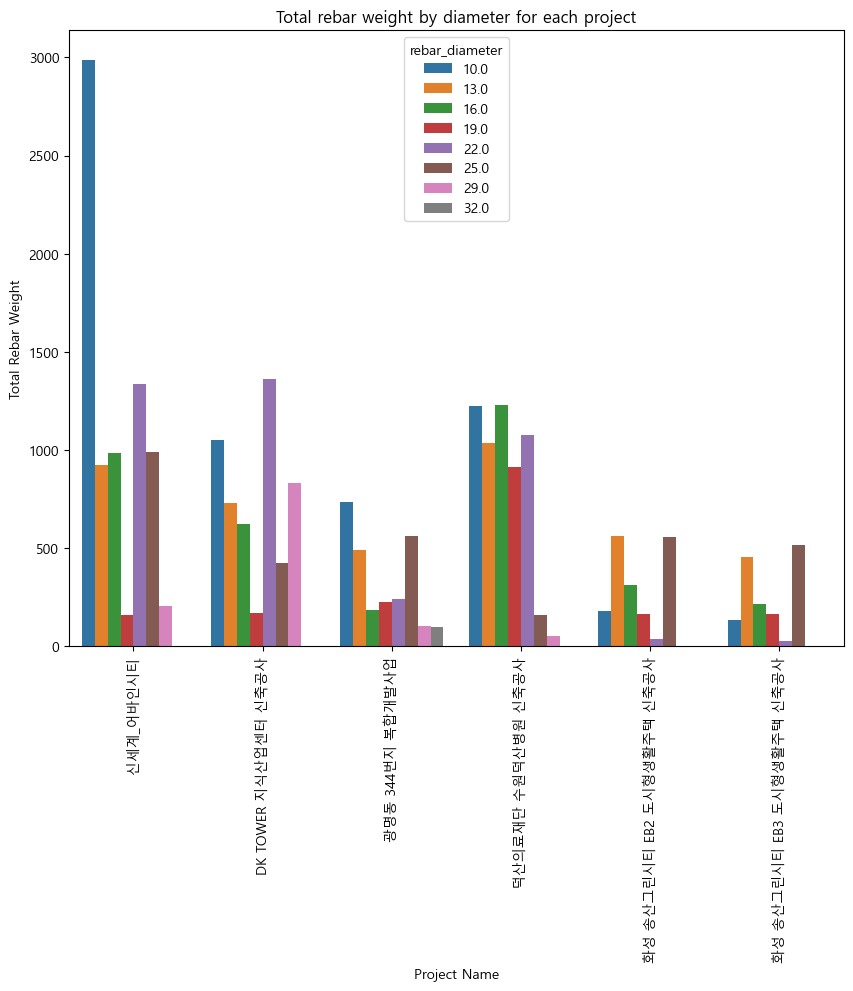

In [20]:
plt.figure(figsize=(10, 8))
sns.barplot(x="project_name", y="total_rebar_weight", hue="rebar_diameter", data=df)
plt.title("Total rebar weight by diameter for each project")
plt.xlabel("Project Name")
plt.ylabel("Total Rebar Weight")
plt.xticks(rotation=90)
plt.show()

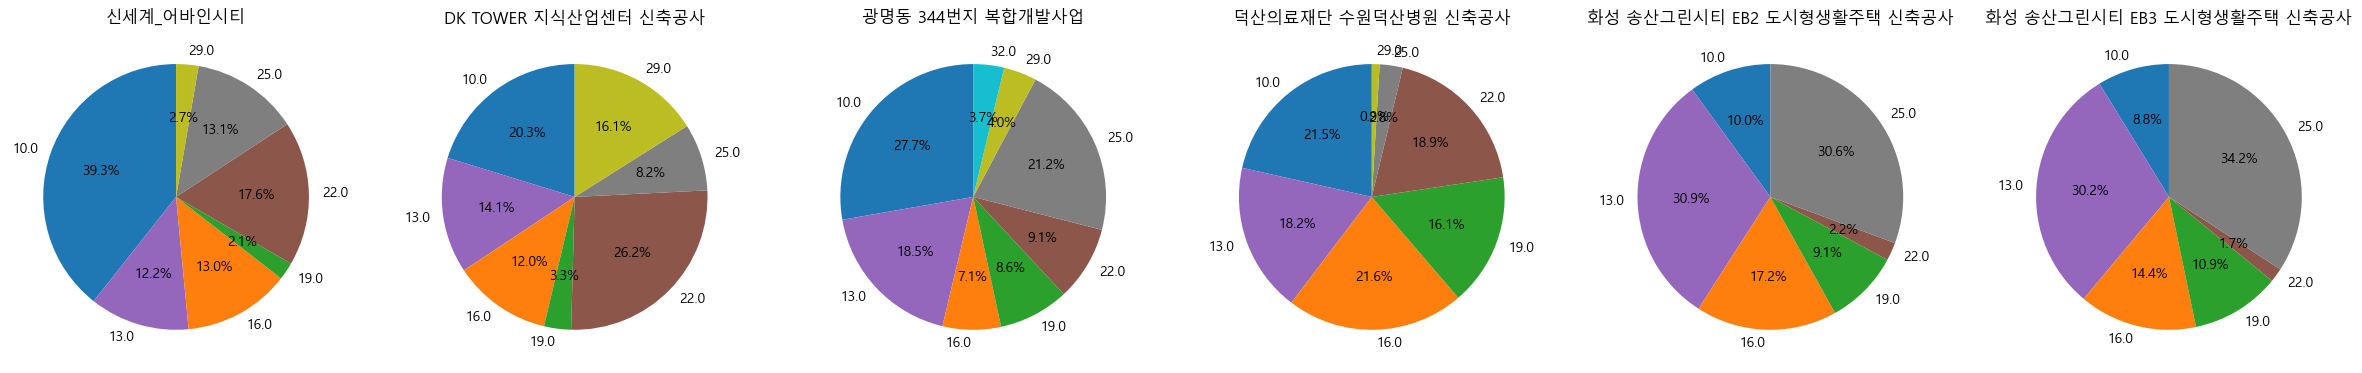

In [21]:


project_names = df['project_name'].unique()

# 컬러 맵을 생성합니다. 각 rebar_diameter에 대해 유일한 색상을 매핑합니다.
unique_diameters = df['rebar_diameter'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_diameters)))
color_map = dict(zip(unique_diameters, colors))

fig, axs = plt.subplots(1, len(project_names), figsize=(30, 10))

for i, project_name in enumerate(project_names):
    data = df[df['project_name'] == project_name]
    # 데이터를 rebar_diameter 기준으로 정렬합니다.
    data = data.sort_values(by='rebar_diameter')
    # 각 파이 슬라이스에 대한 색상을 선택합니다.
    slice_colors = [color_map[diameter] for diameter in data['rebar_diameter']]
    axs[i].pie(data['total_rebar_weight'], labels=data['rebar_diameter'], autopct='%1.1f%%', colors=slice_colors, startangle=90)
    axs[i].set_title(project_name)

plt.show()

In [22]:

# def aggregate_weight_volume_ratio(engine):
#     query = """
#     SELECT 
#         c.component_type, 
#         SUM(r.rebar_weight) / SUM(c.volume) as weight_volume_ratio
#     FROM 
#         rebar r
#     JOIN 
#         concrete c ON r.floor_id = c.floor_id
#     WHERE
#         r.component_type = c.component_type
#     GROUP BY 
#         c.component_type
#     """
#     df = pd.read_sql(query, engine)
#     return df

# df = aggregate_weight_volume_ratio(engine)

# # 각 component_type별로 평균과 표준편차를 계산합니다.
# summary_df = df.groupby('component_type').agg(['mean', 'std'])

# # Boxplot을 그립니다.
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df, x='component_type', y='weight_volume_ratio')
# plt.title('Rebar Weight / Concrete Volume by Component Type')
# plt.ylabel('Weight/Volume Ratio')
# plt.show()
